In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import librosa
import librosa.display
import IPython.display as ipd

In [105]:
db_audio = pd.read_csv("info.csv")


def list_from_db(db_audio):
    list_of_samples = []
    for dataset in db_audio.iterrows():
        if dataset[1].beat_type=="beat":
            list_of_samples.append((dataset[1].duration, dataset[1].audio_filename, dataset[1].style, dataset[1].bpm))
    return list_of_samples

#list_from_db = list_from_db(db_audio)


def extracting_spectograms(list_from_db, desired_length, pause=1):
    preprocessed_data = []
    for audio_sample in list_from_db:
        filename = audio_sample[1]
        length = audio_sample[0]
        style = audio_sample[2]
        bpm = audio_sample[3]
        
        if length < desired_length: 
            x, sr = reading_audiofile(filename, modus_operandi="repeat",
                              desired_length=desired_length, offset=0.0, pause=pause)
            Xdb = spectogram(x, sr)
            preprocessed_data.append([Xdb, style, bpm])
            
        if length > desired_length:
            steps=int(length//desired_length)
            for i in range(steps):
                x, sr = reading_audiofile(filename, modus_operandi="no_change",
                            desired_length=desired_length, offset=i*desired_length)
                Xdb = spectogram(x, sr)
                preprocessed_data.append([Xdb, style, bpm])
                
            x, sr = reading_audiofile(filename, modus_operandi="repeat",
                                desired_length=desired_length, offset=steps*desired_length, pause=pause)
            Xdb = spectogram(x, sr)
            preprocessed_data.append([Xdb, style, bpm])
                
    return preprocessed_data

#prepoc=extracting_spectograms(list_from_db, desired_length=6, pause=1)

FileNotFoundError: [Errno 2] No such file or directory: 'drummer1/eval_session/1_funk-groove1_138_beat_4-4.wav'

In [97]:
def reading_audiofile(filename, modus_operandi="no_change", desired_length=6, offset=0.0, pause=1):
    ''' reading in audiofiles
        requires filename (with path)
                modus_operandi:  "no_change" -> reading in audiofile in length, no padding
                                 "silence"-> padding smaller (than desired length) audio files with silence
                                 "repeat" -> padding smaller audio files with repetitive sound (+ pauses)
                desired_length:  in sec, if prespecified length is requested (default value 30)
                                 does not apply if "no_change" modus is chosen
                pause:           in sec, if modus "repeat" is chosen: if a pause between repetions is asked
        returns x (nd-array), sr (sample rate)
    '''

    if modus_operandi=="no_change":
         x , sr = librosa.load(filename, duration=desired_length, offset=0.0)

    if modus_operandi=="repeat":
        # == filling up smaller samples with repeated sounds ==
        x , sr = librosa.load(filename, duration= desired_length, offset=0.0)
        duration = x.shape[0]/sr        # in seconds
        if duration < desired_length:
            pause = int(pause * sr)     # seconds (first number) * sampling rate
            multiplier = int(desired_length // duration)
            single_x=np.append(np.zeros(pause),x)
            for i in range(multiplier):
                x = np.append(x, single_x)
            x=x[0:desired_length*sr]

    if modus_operandi=="silence":
        # == filling up smaller samples with silence ==
        x , sr = librosa.load(filename, duration= desired_length)
        duration = x.shape[0]/22000        # in seconds
        if duration < desired_length:
            filling_zeros = desired_length * sr - x.shape[0]
            x = np.append(x, np.zeros(filling_zeros))
            x=x[0:desired_length*sr]

    return x, sr

def spectogram(x, sr):
#  ===  1 Spectogram  ===
#  requires 1-dimensional array x(timeseries), sampling rate sr
#  returns spectogram, a matplotlib.colormesh object

    #performing short time- Fourier analysis
    X = librosa.stft(x)

    #amplitudes of given frequency at given time -> spectrogram
    Xdb = librosa.amplitude_to_db(abs(X))

    #plt.figure(figsize=(10, 10), dpi=50, frameon=False)
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') # for demonstration purposes
    #spect_audio = librosa.display.specshow(Xdb, sr=sr, x_axis=None, y_axis=None, cmap="Greys") # without axes
    return Xdb

In [50]:
directory = "/home/michael/code/vickoru/drumbeatid/data"
audiofile = "example2.wav"
filename=directory+"/"+audiofile

x, sr =  reading_audiofile(filename, modus_operandi="repeat", desired_length=6, pause=0)
spec_audio = spectogram(x,sr)

In [51]:
spec_audio.shape

(1025, 259)

In [44]:
ipd.Audio(x, rate=sr)

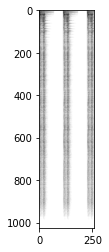

In [38]:
plt.imshow(spec_audio, cmap="Greys")

In [92]:
# def mfcc(x, sr):
# #  ==== 2 Mel Frequency Cepstral Coefficients (MFCCs) ===
# #  requires 1-dimensional array x(timeseries), sampling rate sr
# # returns mfcc, a matplotlib.colormesh object

#     mfccs = librosa.feature.mfcc(y=x, sr=sr)

#     plt.figure(figsize=(5, 1), dpi=2)
#     mfcc = librosa.display.specshow(mfccs, sr=sr, x_axis='time')
#     return mfcc

#     #### used for demonstration:
# directory = "/home/michael/code/vickoru/drumbeatid/data"
# audiofile = "example3.wav"
# filename=directory+"/"+audiofile

# x, sr =  reading_audiofile(filename, modus_operandi="no_change", desired_length=20, pause=0)
# spectogram(x, sr)

# #plt.figure(figsize=(8, 6))
# #img_representation = plt.imshow(Xdb,cmap="Greys")
# img_representation = plt.imshow(Xdb,aspect=.05,cmap="Greys")  #aspect to make it visible for human eye